In [1]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


<h2>STEP 1 : 시계열 데이터 준비</h2>

이 과정에서 과거의 시계열 데이터를 통해 실제 주식값을 예측할 것이다.

삼성전자에 대한 주식을 우선 예측해보겠다

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성 #코드 넣기\
csv_path = os.getenv("HOME") + '/aiffel/stock_prediction/data/005930.KS.csv'
data = pd.read_csv(csv_path, index_col='Date', parse_dates=True) #시계열 데이터로 할 것이므로 index에 date를 넣는다
ts = data['Close']
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

<H2>STEP 2 : 각종 전처리 수행</H2>

 -  결측치 처리 : 결측치가 존재할 경우 시계열데이터에서 엄청난 문제가 생길수 있으므로 보간을 하던지 없애버린다.
    
    
 -  로그 변환 : 보통 추세에 의해서 그래프가 상승할경우엔 MA를 빼줘야 하고, 그래프의 변동폭이 점점 늘어날 경우 log변환을 통해 stationary하
 
       게 변경해준다. <b>decomposing 시계열 분해의 과정중 하나</b>이다.

<h3> 결측치 처리 </h2>

In [3]:
# 결측치 처리
# 보간 방법을 택했다.  - 본 데이터에서는 결측치가 없었다.
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

<h3>로그 변환</h3>

In [4]:
ts_log = np.log(ts)
ts_log.head()

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
Name: Close, dtype: float64

<h2>STEP 3 : 시계열 안정성 분석</h2>

- 정성적 그래프 분석 : ACF와 PACF 그래프를 그려볼것이다.
- 정량적 Augmented Dicky-Fuller Test :ADF test를 통해 p-value값을 보며 최적의 모수들을 찾는다(p,d,q)
- 시계열 분해(Time Series Decomposition) : decomposition
- Residual 안정성 확인 : 


In [5]:
#정성적 그래프 메소드
def plot_rolling_statistics(timeseries, window=12):
    #이동평균, 이동표준편차 시계열
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    #원본시계열, 이동평균, 이동표준편차 plot으로 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label="Rolling Mean")
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling mean & Rolling Standard Deviation')
    plt.show(block=False)



In [6]:
#정량적 ADF TEST 함수
from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Result of Dickey-Fuller Test:')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic', 'p-value','#Lags Used', 'Numbers of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

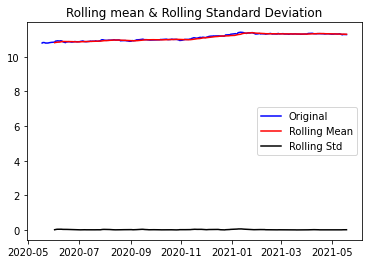

Result of Dickey-Fuller Test:
Test Statistic                   -1.383525
p-value                           0.590149
#Lags Used                        0.000000
Numbers of Observations Used    249.000000
Critical Value (1%)              -3.456888
Critical Value (5%)              -2.873219
Critical Value (10%)             -2.572994
dtype: float64


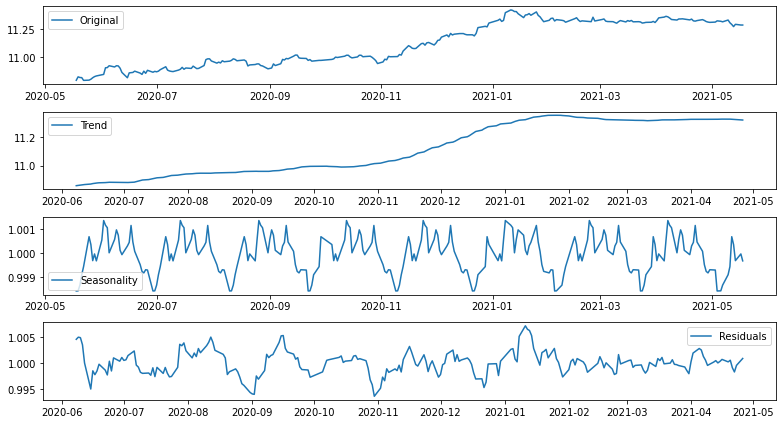

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

# [[YOUR CODE]]
from matplotlib.pylab import rcParams
trend = decomposition.trend
seasonal = decomposition.seasonal
residual= decomposition.resid

plt.rcParams["figure.figsize"]=(11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best') 
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [8]:
# Residual 안정성 확인
residual.dropna(inplace =True)
residual
augmented_dickey_fuller_test(residual)
#기존의  p-value는 0.590149였는데 dropna를 통해 NAN값들을 없애고 다시 adf test를 돌려보니 p-value가 6.234854e-08가 됬다 - 귀무 거짓


Result of Dickey-Fuller Test:
Test Statistic                 -6.187586e+00
p-value                         6.234854e-08
#Lags Used                      9.000000e+00
Numbers of Observations Used    2.100000e+02
Critical Value (1%)            -3.461879e+00
Critical Value (5%)            -2.875404e+00
Critical Value (10%)           -2.574159e+00
dtype: float64


<h2>STEP 4 : 학습, 테스트 데이터셋 생성</h2>

- 학습, 테스트 데이터셋을 분리한다

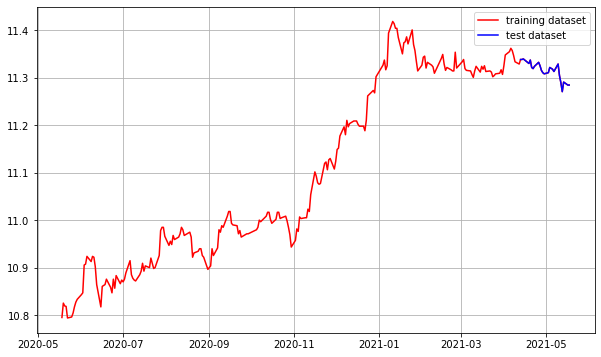

In [9]:
#from sklearn_model_selection import train_test_split
#로그변환된 ts_log 를 
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
#실행하게되면 ts_log[:]인것과 ts_log[int(len(ts_log)*0.9):] 의 그래프가 서로 마지막부분에 겹치게된다 
#이후에 실행한 plot에 의해 덮어씌워지므로 9:1로 나뉜 부분의 9 막바지에 파란색 c='b'로 test_dataset이 그려진다


<h2>STEP 5 : 적정 ARIMA 모수 찾기</h2>

- ACF, PACF 그려보기 -> p,q 구하기

- 차분 안정성 확인 -> d 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


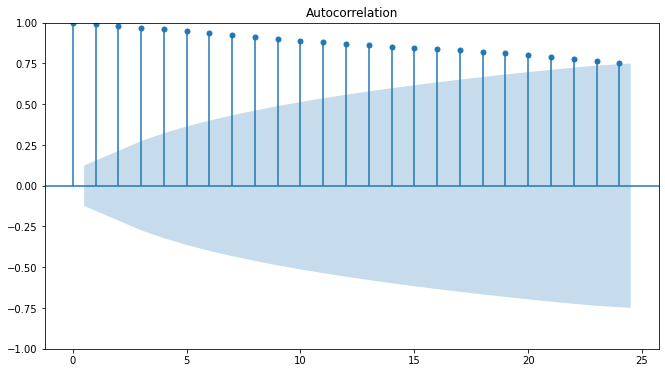

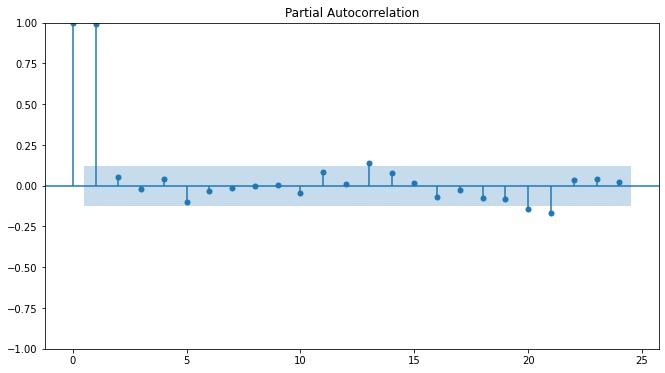

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log) #autocorrelation function  그래프
plot_pacf(ts_log) #partial acf 그래프

plt.show()

#그래프를 보면 acf는 감소추세인데, pacf에서는 lag=1이후로 값이 0에 가까워졌다
#pacf에서 시차 p이후에 0이므로 AR(p)로 하고 적용될 모델은 AR(1)이다.


Result of Dickey-Fuller Test:
Test Statistic                 -1.553699e+01
p-value                         2.183738e-28
#Lags Used                      0.000000e+00
Numbers of Observations Used    2.480000e+02
Critical Value (1%)            -3.456996e+00
Critical Value (5%)            -2.873266e+00
Critical Value (10%)           -2.573019e+00
dtype: float64


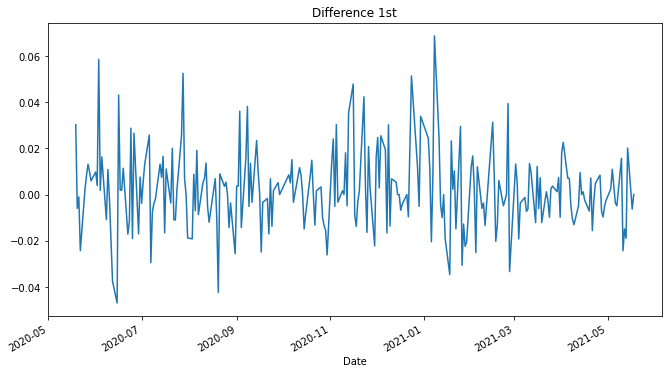

In [11]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="Difference 1st")

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
#diff_2 = diff_1.diff(periods=1).iloc[1:]
#diff_2.plot(title='Difference 2nd')

#ugmented_dickey_fuller_test(diff_2)
#p-value                         2.183738e-28

이 모델은 ACF는 점차감소 , PACF가 p=1이후 0이므로 AR모델이라고 볼수 있고, 차분을 했을때 lags used가 0이므로 모델은 010으로 한다.
#Lags Used                      0.000000e+00

<h2>STEP 6 : ARIMA 모델 훈련과 테스트</h2>

- ARIMA 모델 빌드와 훈련

- 모델 테스트 및 플로팅

- 최종 예측 모델 정확도 측정(MAPE)

In [12]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(0,1,0))
fitted_m = model.fit()
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 583.363
Date:                Sun, 20 Nov 2022   AIC                          -1164.726
Time:                        19:48:17   BIC                          -1161.314
Sample:                             0   HQIC                         -1163.349
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   2.33e-05     13.751      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                22.25
Prob(Q):                              0.80   Pr

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


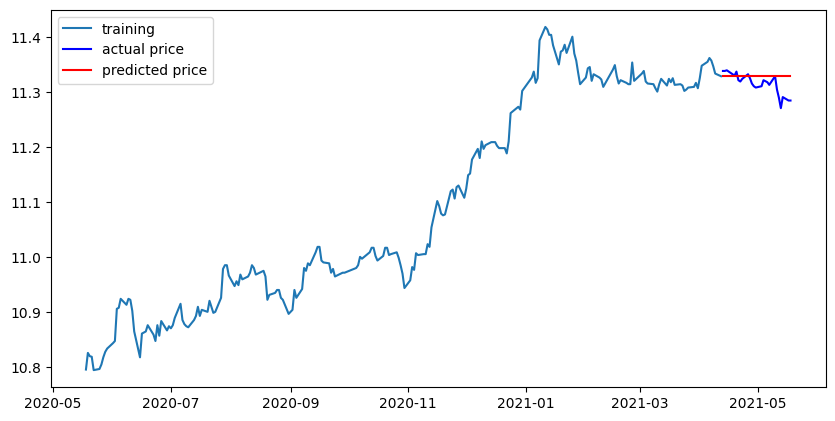

In [13]:
# Forecast 결과가 fc에 담깁니다
fc = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf
fc = np.array(fc)
# make as pandas series
fc_series = pd.Series(fc, index=test_data.index) #예측결과

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()
#대체 어떻게 모수를 찾아서 arima모델에 넣었는진 도저히모르겠다
#일단 예시로 집어넣어서 2,0,1,로 넣었다..

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))# [[YOUR CODE]]
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc)) # [[YOUR CODE]]
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))# [[YOUR CODE]]
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3509600.000000066
MAE:  1408.0000000000023
RMSE:  1873.3926443754567
MAPE: 1.74%


<h2>STEP 7 : 다른 주식 종목 예측해 보기</h2>
어떤 종목으로 해볼까

kakao

TSLA

In [15]:
csv_path = os.getenv("HOME") + '/aiffel/stock_prediction/data/035720.KS.csv'

STEP 1 : 시계열 데이터 준비

STEP 2 : 각종 전처리 수행

STEP 3 : 시계열 안정성 분석

STEP 4 : 학습, 테스트 데이터셋 생성

STEP 5 : 적정 ARIMA 모수 찾기

STEP 6 : ARIMA 모델 훈련과 테스트

<h2> KAKAO 주식으로 데이터 예측</h2>

In [16]:
#STEP1
#시계열 데이터를 준비해보자.
data2 = pd.read_csv(csv_path, index_col='Date', parse_dates=True) #시계열 데이터로 할 것이므로 index에 date를 넣는다
data2.head()
ts = data2['Close']
ts.head()


Date
2021-11-15    129948.625000
2021-11-16    128437.593750
2021-11-17    125919.210938
2021-11-18    125415.531250
2021-11-19    127933.914063
Name: Close, dtype: float64

In [17]:
#STEP2-1 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [18]:
#STEP2-2 로그변환
ts_log = np.log(ts)
ts_log.head()

Date
2021-11-15    11.774894
2021-11-16    11.763198
2021-11-17    11.743396
2021-11-18    11.739388
2021-11-19    11.759269
Name: Close, dtype: float64

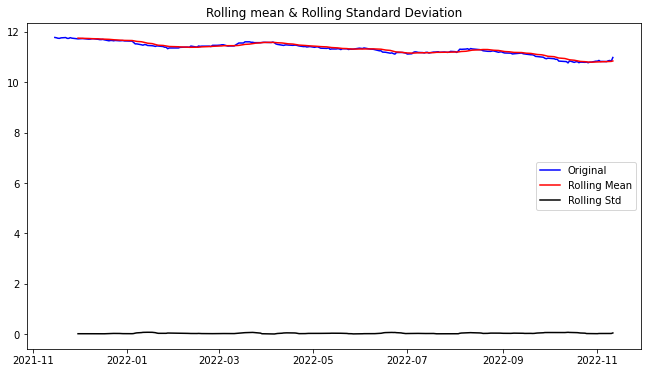

Result of Dickey-Fuller Test:
Test Statistic                   -1.173888
p-value                           0.684726
#Lags Used                        3.000000
Numbers of Observations Used    240.000000
Critical Value (1%)              -3.457894
Critical Value (5%)              -2.873659
Critical Value (10%)             -2.573229
dtype: float64


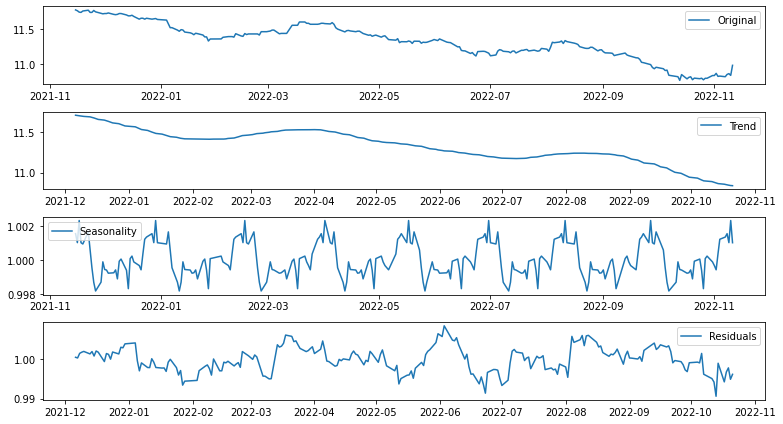

In [19]:
#STEP3-1
# 1 plot_rolling_statistics(ts, window=12) = 정성적 그래프 메소드 - 이동평균 이동표준편차 시계열 시각화
# 2 augmented_dickey_fuller_test(ts) = 정량적 ADF TEST 함수 p-value 확인용
# 3 시계열분해 seasonal_decompose -> trend, seasonal, residual

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

from matplotlib.pylab import rcParams
trend = decomposition.trend
seasonal = decomposition.seasonal
residual= decomposition.resid

plt.rcParams["figure.figsize"]=(11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best') 
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [20]:
#residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
#0.001725


Result of Dickey-Fuller Test:
Test Statistic                   -3.945435
p-value                           0.001725
#Lags Used                        4.000000
Numbers of Observations Used    209.000000
Critical Value (1%)              -3.462032
Critical Value (5%)              -2.875471
Critical Value (10%)             -2.574195
dtype: float64


In [21]:
augmented_dickey_fuller_test(ts_log)

Result of Dickey-Fuller Test:
Test Statistic                   -1.173888
p-value                           0.684726
#Lags Used                        3.000000
Numbers of Observations Used    240.000000
Critical Value (1%)              -3.457894
Critical Value (5%)              -2.873659
Critical Value (10%)             -2.573229
dtype: float64


adf test를 통해 p-value가 0.001725로 안정성있는 값이 도출되었다



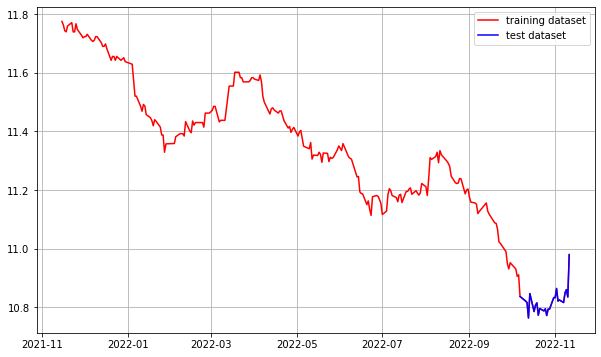

In [22]:
#4-1학습, 훈련 데이터셋 생성하기
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


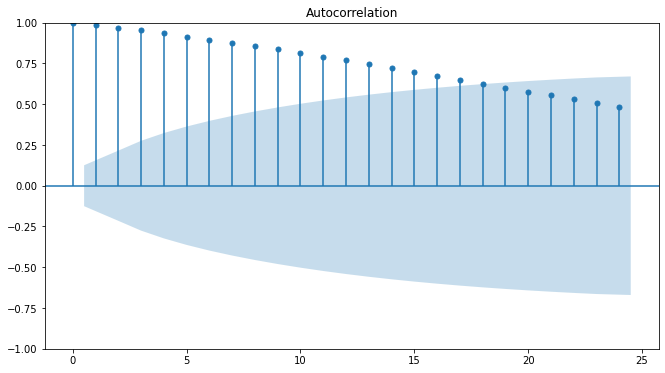

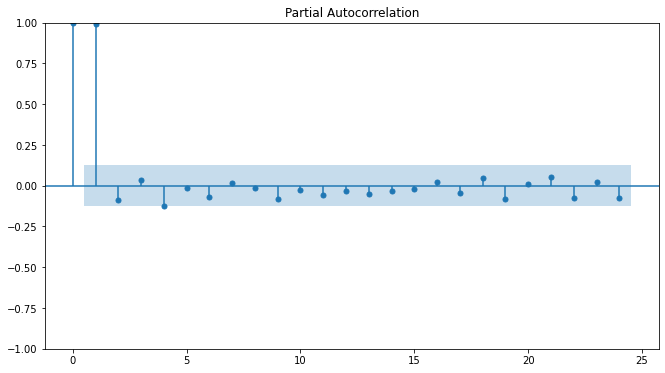

In [23]:
#STEP 5 : 적정 ARIMA 모수 찾기
#step 5-1 ACF, PCAF 그려보기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()
#그래프를 보면 AR모델에 p=1인 경우이다


시차 4이후 유의한 구간에 들어간다

Result of Dickey-Fuller Test:
Test Statistic                 -7.053170e+00
p-value                         5.459834e-10
#Lags Used                      2.000000e+00
Numbers of Observations Used    2.400000e+02
Critical Value (1%)            -3.457894e+00
Critical Value (5%)            -2.873659e+00
Critical Value (10%)           -2.573229e+00
dtype: float64
Result of Dickey-Fuller Test:
Test Statistic                 -7.620978e+00
p-value                         2.128914e-11
#Lags Used                      1.100000e+01
Numbers of Observations Used    2.300000e+02
Critical Value (1%)            -3.459106e+00
Critical Value (5%)            -2.874190e+00
Critical Value (10%)           -2.573512e+00
dtype: float64


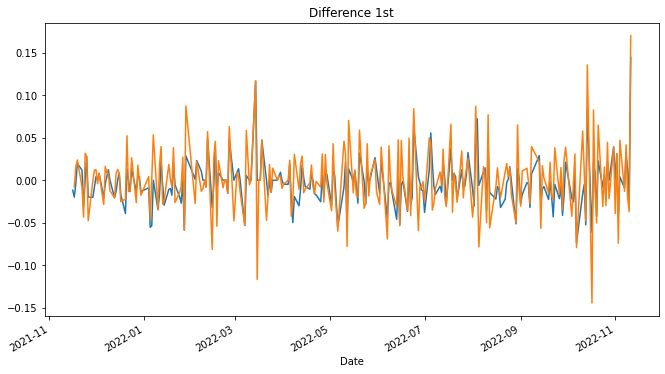

In [24]:
#step 5-2 : 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="Difference 1st")

augmented_dickey_fuller_test(diff_1)
#일단 ts_log의 p-value가 0.6X이고, diff_1의 p-value는 5.459834e-10 이다. 1차 차분을 해야한다.
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title="Difference 1st")

augmented_dickey_fuller_test(diff_2)

PACF p=1에서 0으로 떨어짐. 1차 차분에서 lags used가 2이므로 2,1,0을 ARIMA 모델의 모수로 사용한다.

In [25]:
import pmdarima
pmdarima.arima.ndiffs(ts_log, alpha=0.05)
#차분이 1 필요하다고 한다.


1

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  219
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 504.825
Date:                Sun, 20 Nov 2022   AIC                          -1003.650
Time:                        19:48:20   BIC                           -993.496
Sample:                             0   HQIC                          -999.548
                                - 219                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0017      0.074      0.023      0.982      -0.143       0.147
ar.L2         -0.0576      0.079     -0.731      0.465      -0.212       0.097
sigma2         0.0006   3.63e-05     15.695      0.0

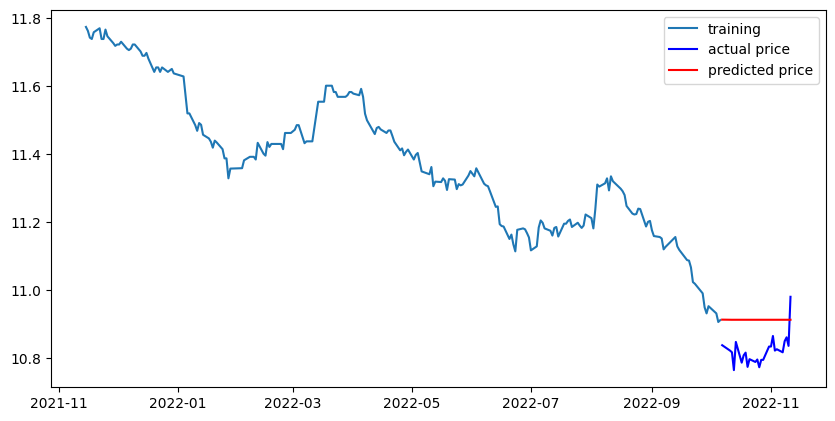

In [26]:
#step 6-1: ARMA 모델 빌드 , 훈련
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2,1,0))
fitted_m = model.fit()
print(fitted_m.summary())

# Forecast 결과가 fc에 담깁니다
fc = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf
fc = np.array(fc)
# make as pandas series
fc_series = pd.Series(fc, index=test_data.index) #예측결과

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()
# acf pacf그래프를 보고난 후, p=1 d=1 q=0으로 넣었다.

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))# [[YOUR CODE]]
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc)) # [[YOUR CODE]]
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))# [[YOUR CODE]]
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  27231372.56384912
MAE:  5040.018019803106
RMSE:  5218.368764647543
MAPE: 10.16%


<h2> TSLA 주식으로 데이터 예측 </h2>

In [28]:
#STEP1
#시계열 데이터를 준비해보자.
csv_path = os.getenv("HOME") + '/aiffel/stock_prediction/data/TSLA.csv'
data3 = pd.read_csv(csv_path, index_col='Date', parse_dates=True) #시계열 데이터로 할 것이므로 index에 date를 넣는다
data3.head()
ts = data3['Close']
ts.head()


Date
2021-11-12    344.473328
2021-11-15    337.796661
2021-11-16    351.576660
2021-11-17    363.003326
2021-11-18    365.459991
Name: Close, dtype: float64

In [29]:
#STEP2-1 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [30]:
#STEP2-2 로그변환
ts_log = np.log(ts)
ts_log.head()

Date
2021-11-12    5.842017
2021-11-15    5.822444
2021-11-16    5.862428
2021-11-17    5.894412
2021-11-18    5.901157
Name: Close, dtype: float64

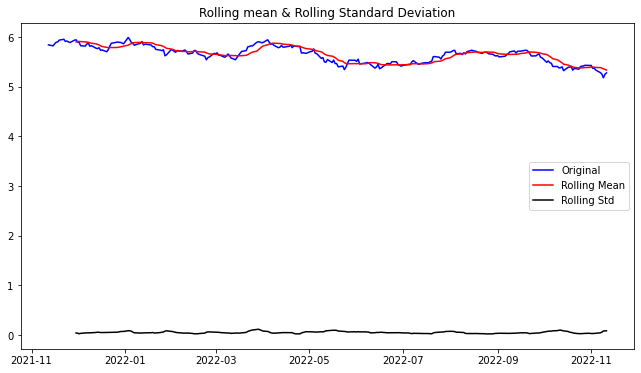

Result of Dickey-Fuller Test:
Test Statistic                   -1.595159
p-value                           0.486025
#Lags Used                       10.000000
Numbers of Observations Used    241.000000
Critical Value (1%)              -3.457779
Critical Value (5%)              -2.873609
Critical Value (10%)             -2.573202
dtype: float64


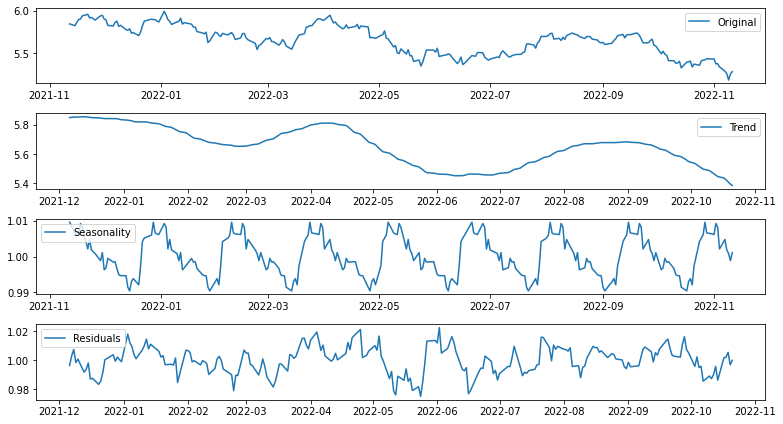

In [31]:
#STEP3-1
# 1 plot_rolling_statistics(ts, window=12) = 정성적 그래프 메소드 - 이동평균 이동표준편차 시계열 시각화
# 2 augmented_dickey_fuller_test(ts) = 정량적 ADF TEST 함수 p-value 확인용
# 3 시계열분해 seasonal_decompose -> trend, seasonal, residual

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

from matplotlib.pylab import rcParams
trend = decomposition.trend
seasonal = decomposition.seasonal
residual= decomposition.resid

plt.rcParams["figure.figsize"]=(11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best') 
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [32]:
#residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
#0.000010


Result of Dickey-Fuller Test:
Test Statistic                   -5.181673
p-value                           0.000010
#Lags Used                        9.000000
Numbers of Observations Used    212.000000
Critical Value (1%)              -3.461578
Critical Value (5%)              -2.875272
Critical Value (10%)             -2.574089
dtype: float64


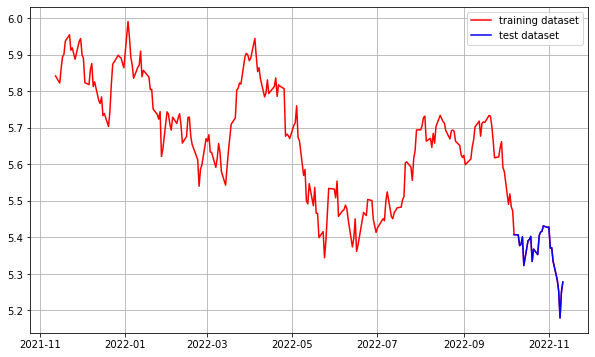

In [33]:
#4-1학습, 훈련 데이터셋 생성하기
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


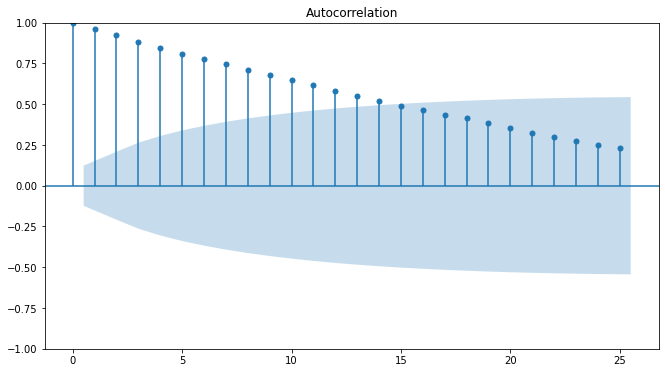

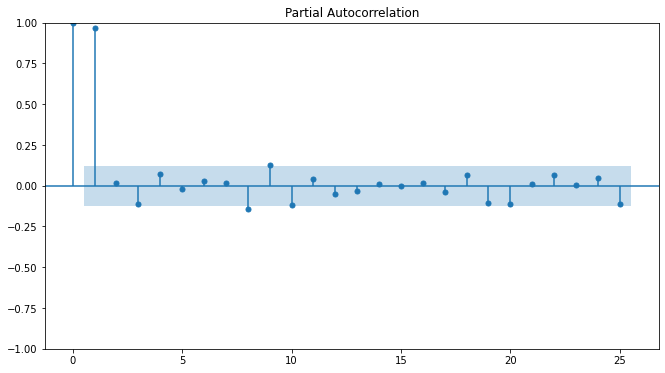

In [34]:
#STEP 5 : 적정 ARIMA 모수 찾기
#step 5-1 ACF, PCAF 그려보기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()
#그래프를 보면 AR모델에 p=1인 경우이다


Result of Dickey-Fuller Test:
Test Statistic                   -4.949664
p-value                           0.000028
#Lags Used                        9.000000
Numbers of Observations Used    241.000000
Critical Value (1%)              -3.457779
Critical Value (5%)              -2.873609
Critical Value (10%)             -2.573202
dtype: float64
Result of Dickey-Fuller Test:
Test Statistic                 -8.108076e+00
p-value                         1.247155e-12
#Lags Used                      1.000000e+01
Numbers of Observations Used    2.390000e+02
Critical Value (1%)            -3.458011e+00
Critical Value (5%)            -2.873710e+00
Critical Value (10%)           -2.573256e+00
dtype: float64


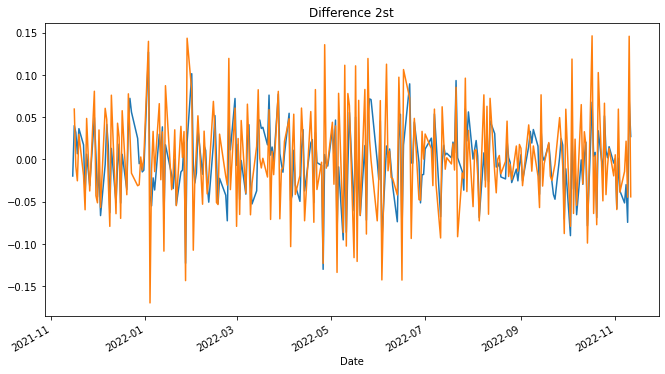

In [35]:
#step 5-2 : 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="Difference 1st")

augmented_dickey_fuller_test(diff_1)
#일단 ts_log의 p-value가 0.48이고, diff_1의 p-value는 0.000028인데

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title="Difference 2st")

augmented_dickey_fuller_test(diff_2)

p-value                           0.000028
p-value                         1.247155e-12
이므로 d=2일때 차이가 더 나므로 d=2로 설정해주겠다.

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                ARIMA(10, 2, 0)   Log Likelihood                 399.758
Date:                Sun, 20 Nov 2022   AIC                           -777.516
Time:                        19:48:24   BIC                           -739.988
Sample:                             0   HQIC                          -762.368
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9019      0.073    -12.395      0.000      -1.044      -0.759
ar.L2         -0.8585      0.096     -8.964      0.000      -1.046      -0.671
ar.L3         -0.8197      0.124     -6.635      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


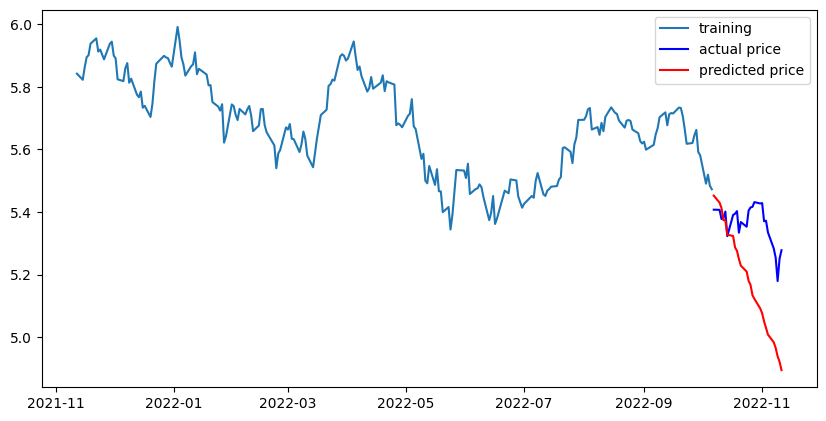

In [36]:
## step 6-1: ARMA 모델 빌드 , 훈련
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(10,2,0))
fitted_m = model.fit()
print(fitted_m.summary())

# Forecast 결과가 fc에 담깁니다
fc = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf
fc = np.array(fc)
# make as pandas series
fc_series = pd.Series(fc, index=test_data.index) #예측결과

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()
#대체 어떻게 모수를 찾아서 arima모델에 넣었는진 도저히모르겠다
#일단 예시로 집어넣어서 2,0,1,로 넣었다..

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1816.2423563750297
MAE:  36.22765178600392
RMSE:  42.61739499752454
MAPE: 17.12%


<h1>회고</h1>
이 노드를 진행하면서 다른 부분은 모두 이해를하고 잘 넘어갔다고 생각하는데

step에서 ACF PACF 그래프를 보고 lag을 본다음 p, d, q를 각각 정하는 과정에서 이게 왜 이 모수가 나오는지 도저히 이해할수가 없었다

따라서 기존에 알고있던 ACF PACF를 보고 0으로 떨어진 그래프의 시차를 기준으로 모수를 정하기로 결정했다.

kakao 주식에서의 close기준 데이터에서 , acf pacf그래프를 그려보았을 때, pacf에서 시차 1 이후 유의구간에 들어감을 알수있다.

Result of Dickey-Fuller Test:

1차 차분 

p-value                         5.459834e-10

#Lags Used                      2.000000e+00

2차 차분 

p-value                         2.128914e-11

#Lags Used                      1.100000e+01

p-value의 차이가 default와 1차차분의 값 차이가 더 많이 차이나기 떄문에 1차차분을 하였다.

기존의 차분 1, lags = 2로 2,1,0으로 두어 그렇게 MAPE 10.16%인 결과가 나왔다..


그리고 테슬라 주식에서는

똑같이 acf 점차하강,  pacf에서 p=1 0으로 떨어지는 AR모델이라 모수 1,1,0으로 설정하였으나 일직선으로 나타나 차분을 더 늘려 진행했다.

그래프의 모습에서 p를 좀더 다루면 다를까싶어 p=2로 설정해보고 했더니 어느정도 추세는 맞는듯 하다.

p-value                           0.000028

#Lags Used                        9.000000

p-value                         1.247155e-12

#Lags Used                      1.000000e+01

1차차분보다 2차차분에서의 결과가 차이가 더 나므로 2차차분 d=2로 두고 lags는 10이므로 p=10, d=2 q=0으로 두겠다.

MAPE: 9.29%인 결과가 나왔다.

<h2>어려웠던점</h2>

그래프 acf, pacf를 보고 p,d,q를 판단한다고 하는데.. 제대로 판단이 안되는 듯 하다

오히려 여러 p,q,d로 실험하며 그리게 되면 추세에 맞게 나오는 그래프가 한두개는 나오는데 그게 정답이 아닐까 싶다.

뭔가 생각되로 안되는 forecasting이 많아서 어렵다 주식이란게 그런 것 같기도 하다.

결론적으로는 과정 자체는 이해를 하였지만 모수설정에 있어 어려움이 있어 힘들었던 것 같다. 결과가 명쾌하지못해 스트레스도 받는다.

kakao주식은 그래프 그대로 설정해서 따랐다면, TSLA 주식은 내맘대로 order을 줘본 것 같다. - 추후 그냥 그래프와 ADF test를 통해

모수를 설정해서 진행했다.
